In [2]:
import numpy as np
import scipy as sp
from PIL import Image

import matplotlib.pylab as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D

import scipy.stats as st
from sortedcontainers import SortedDict
from skimage.restoration import unwrap_phase

from IPython.display import HTML

import math
import random

from scipy.optimize import curve_fit, minimize

In [3]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 10)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
def show_wave(wave):
    fig,ax = plt.subplots(1,2)
    ax1 = ax[0]
    ax2 = ax[1]

    ax[0].set_title("Magnitude")
    ax[1].set_title("Phase")
    
    wave_abs = np.abs(wave)
    wave_phase = np.angle(wave)
        
    plt1 = ax1.imshow(wave_abs)
    plt2 = ax2.imshow(wave_phase)

In [5]:
class WaveAnimation(animation.TimedAnimation):
    def __init__(self,data):
        fig,ax = plt.subplots(1,2)
        self.ax1 = ax[0]
        self.ax2 = ax[1]
        
        ax[0].set_title("Magnitude")
        ax[1].set_title("Phase")
        
        self.data = data
        self.t = len(data)

        animation.TimedAnimation.__init__(self, fig, interval=1000, blit=True)

    def _draw_frame(self, framedata):
        i = framedata#-1
        wave_abs = np.abs(self.data[i])
        wave_phase = np.angle(self.data[i])
        
        plt1 = self.ax1.imshow(wave_abs)
        plt2 = self.ax2.imshow(wave_phase)
        self._drawn_artists = [plt1,plt2]

    def new_frame_seq(self):
        return iter(range(self.t))

    def _init_draw(self):
        wave_abs = np.abs(self.data[0])
        wave_phase = np.angle(self.data[0])
        
        plt1 = self.ax1.imshow(wave_abs)
        plt2 = self.ax2.imshow(wave_phase)
        
    def close(self):
        plt.close()

In [6]:
class WaveAnimationWithHist(animation.TimedAnimation):
    def __init__(self,data):
        fig,ax = plt.subplots(1,3)
        self.ax1 = ax[0]
        self.ax2 = ax[1]
        self.ax3 = ax[2]
        
        ax[0].set_title("Magnitude")
        ax[1].set_title("Phase")
        ax[2].set_title("Histogram")
        
        self.data = data
        self.t = len(data)

        animation.TimedAnimation.__init__(self, fig, interval=1000, blit=True)

    def _draw_frame(self, framedata):
        i = framedata#-1
        wave_abs = np.abs(self.data[i])
        wave_phase = np.angle(self.data[i])
        
        plt1 = self.ax1.imshow(wave_abs)
        plt2 = self.ax2.imshow(wave_phase)
        plt3 = self.ax3.hist(wave_abs.flatten(),30)
        self._drawn_artists = [plt1,plt2]

    def new_frame_seq(self):
        return iter(range(self.t))

    def _init_draw(self):
        wave_abs = np.abs(self.data[0])
        wave_phase = np.angle(self.data[0])
        
        plt1 = self.ax1.imshow(wave_abs)
        plt2 = self.ax2.imshow(wave_phase)
        plt3 = self.ax3.hist(wave_abs.flatten(),30)
        
    def close(self):
        plt.close()

In [7]:
def get_kernel(wavelength,z,dx,dy,x,y):
    kernelFactor = 2*math.pi*z/wavelength
    
    dfx = 1/(dx*x)
    dfy = 1/(dy*y)
    
    # Count up then down eg: [0,1,2,1,0]
    if x % 2 == 0:
        x2 = np.append(np.arange(x/2),np.flip(np.arange(x/2)))
    else:
        x2 = np.append(np.arange((x/2)-1),[math.ceil(x/2)])
        x2 = np.append(x2,np.flip(np.arange((x/2)-1)))
        
    if y % 2 == 0:
        y2 = np.append(np.arange(y/2),np.flip(np.arange(y/2)))
    else:
        y2 = np.append(np.arange((y/2)-1),[math.ceil(y/2)])
        y2 = np.append(y2,np.flip(np.arange((y/2)-1)))
    
    l = x2 - (x/2) + 1
    l2 = (l**2) * (dfx**2)
    
    m = y2 - (y/2) + 1
    m2 = (m**2) * (dfy**2) + 1
    
    l2 = np.arange(x)-int(x/2)
    m2 = np.arange(y)-int(y/2)
    
    l3 = np.broadcast_to(l2, (y,x)).transpose()
    m3 = np.broadcast_to(m2, (x,y))
    
    kernelPhase = np.power(1 - (wavelength*l3/dx)**2 - (wavelength*m3/dy)**2,(1/2)) * kernelFactor
    
    real = np.cos(kernelPhase)
    img = 1j*np.sin(kernelPhase)
    
    return real+img

(512, 512)


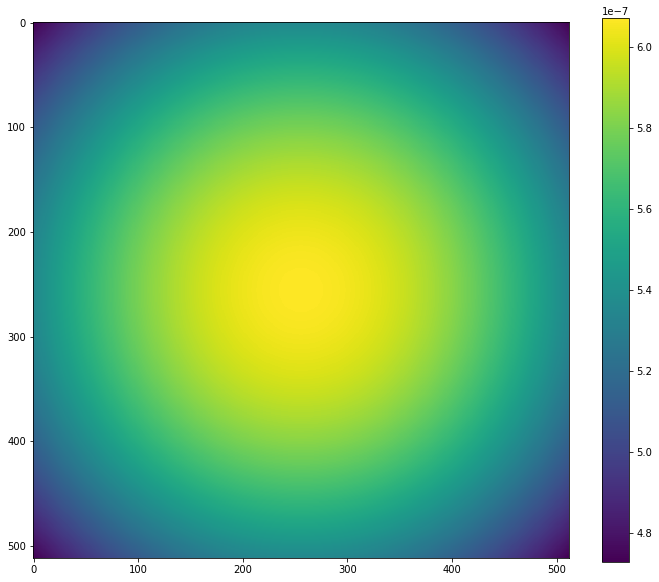

In [8]:
# https://stackoverflow.com/questions/28342968/how-to-plot-a-2d-gaussian-with-different-sigma

#TODO: Get sigma, size right
def generate_gaussian_grid(size_x,size_y,sigma_x=3.,sigma_y=3.):
    #size_x *= 2
    #size_y *= 2
    
    x = np.linspace(-int(size_x/2), int(size_x/2), size_x)
    y = np.linspace(-int(size_y/2), int(size_y/2), size_y)

    x, y = np.meshgrid(x, y)
    z = (1/(2*np.pi*sigma_x*sigma_y) * np.exp(-(x**2/(2*sigma_x**2) + y**2/(2*sigma_y**2))))
    #plt.contourf(x, y, z, cmap='Blues')
    #plt.colorbar()
    #plt.show()
    
    #z = z[int(size_y/2):,:int(size_x/2)].transpose()
    
    return z

#print(z.shape)

#plt.contourf(x, y, z, cmap='Blues')
#plt.colorbar()
#plt.show()

gauss = generate_gaussian_grid(512,512,512,512)
plt.imshow(gauss)
plt.colorbar()
#plt.hist(gauss.flatten(),50)
print(gauss.shape)

-1.9984014443252818e-15
1.0


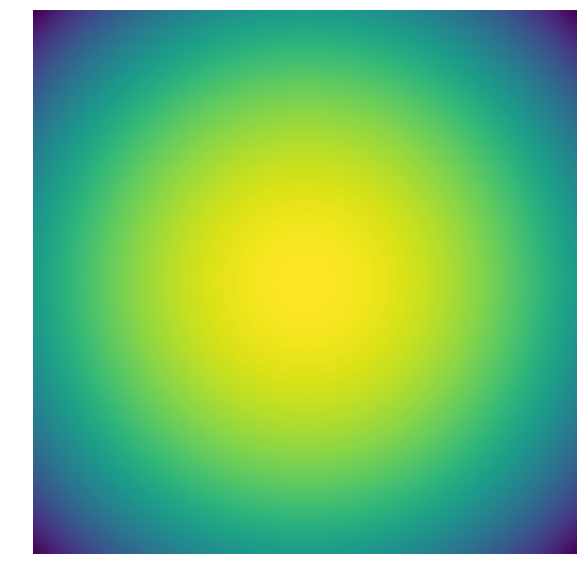

In [9]:
def gen_sphere(x,y,r=50):
    #x *= 2
    #y *= 2
    circ = np.zeros((x,y))

    r2 = np.power(r,2)
    
    pos_x = x/2
    pos_y = y/2
    
    for i in range(x):
        x2 = np.power(i-pos_x,2)
        for j in range(y):
            
            circ[i][j] = np.power(max(0,r2-(x2+np.power(j-pos_y,2))),1/2)
            
    circ = sp.ndimage.filters.gaussian_filter(circ,sigma=3)
    
    mean = np.mean(circ)
    sd = np.std(circ)
    
    circ = (circ-mean)/sd
    
    return circ

sphere = gen_sphere(512,512,512)
plt.imshow(sphere)
plt.axis('off')

print(np.mean(sphere))
print(np.std(sphere))

In [10]:
def get_gauss_beam(x,y):
    #gauss = generate_gaussian_grid(x,y,x*0.05,y*0.05).transpose()
    #sphere = gen_sphere(x,y,x*0.05)
    gauss = generate_gaussian_grid(x,y,x*0.4,y*0.4).transpose()
    sphere = gen_sphere(x,y,x*0.4)
    gauss = gauss * (np.cos(sphere) + 1j*np.sin(sphere))
    #gauss = gauss * (np.cos(np.ones((x,y))) + 1j*np.sin(np.ones((x,y))))
    return gauss

In [11]:
# https://stackoverflow.com/questions/12141150/from-list-of-integers-get-number-closest-to-a-given-value
def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        before = None
        after = None
    elif pos == len(myList):
        before = myList[-1]
        after = None
    else:
        before = myList[pos - 1]
        after = myList[pos]
    
    return before, after

'''
    0 - reject
    1 - accept
    2 - unsure
'''
def check(keys,sd,uni,sam):
    hi = len(keys)
    lo = 0
    
    if hi == 1:
        return 2
    
    if hi == 2:
        if keys[0] < uni and sam > sd.get(keys[0]):
            return 0
            
        if keys[1] > uni and sam < sd.get(keys[1]):
            return 1
        return 2
        
    
    while lo < hi:
        mid = (lo+hi)//2
        mk = keys[mid]
        if mk < uni and sam > sd.get(mk):
            return 0
        if mid < (hi-1):    
            mk2 = keys[mid+1]
            if mk2 > uni and sam < sd.get(mk2):
                return 1
        
        if mk < uni: lo = mid+1
        else: hi = mid
    return 2

In [12]:

class speckle_noise(st.rv_continuous):
    mu = 0.95
    sd = SortedDict([])
    
    def _pdf(self,epsilon):
        b = np.abs(self.mu) * np.cos(epsilon)
        f = (1-np.power(np.abs(self.mu),2))/(2*np.pi)
        g = np.power(1-np.power(b,2),(-3/2))
        h = (b * np.arcsin(b))+((np.pi*b)/2) + np.power(1-np.power(b,2),(1/2))

        return f*g*h
        
    def rvs(self,size):
        res = []
        pdf = self._pdf(0)
        
        self.sd.update([(0,pdf)])
        self.keys = list(self.sd.keys())
        
        while len(res) < size:
            uni = np.random.uniform(0,self.b) # Since the function is mirrored around 0
            sam = np.random.uniform(0,pdf)
            
            c = check(self.keys,self.sd,uni,sam)
            
            if c == 0:
                continue
            if c == 1:
                sign = np.random.randint(2)+1
        
                res.append(uni*((-1)**sign))
                continue
            
            pdf_val = self._pdf(uni)
            if sam < pdf_val:
                sign = np.random.randint(2)+1
        
                res.append(uni*((-1)**sign))
                self.sd.update([(uni,pdf_val)])
                self.keys = list(self.sd.keys())

        return np.array(res)

noise_dist = speckle_noise(a=-math.pi, b=math.pi, name='speckle')
    
def generate_noise(x,y):
    noise = noise_dist.rvs(size=(x*y))
    noise = noise.reshape((x,y))
    
    return noise

In [13]:
max_size = 15

def gen_rand_sizes(i):
    sum_i = 0
    list_i = []
    
    while sum_i < (i-1):
        r = random.randint(1,min(max_size,i-(sum_i-1)))
        list_i.append(r)
        sum_i+=r
        
    return list_i

def gen_noise_random_size(x,y):
    x_list = gen_rand_sizes(x)
    y_list = gen_rand_sizes(y)
    
    #noise = noise_dist.rvs(size=(len(x_list)*len(y_list)))
    #noise = np.random.uniform(size=(len(x_list)*len(y_list)))
    #noise = np.random.normal(scale=0.6782018766824356,size=(len(x_list)*len(y_list)))
    noise = np.random.normal(scale=0.8,size=(len(x_list)*len(y_list)))
    
    noise_mat = np.zeros((x,y))
    
    current_x = 0
    current_y = 0
    
    noise_counter = 0
    
    for block_x in x_list:
        current_y = 0
        for block_y in y_list:
            noise_mat[current_x:current_x+block_x,current_y:current_y+block_y] = noise[noise_counter]
            current_y += block_y
            noise_counter += 1
        current_x += block_x
            
    #noise_mat = sp.ndimage.filters.gaussian_filter(noise_mat,sigma=3)
    
    #mean = np.mean(noise_mat)
    #sd = np.std(noise_mat)
    
    #noise_mat = (noise_mat-mean)/np.max(noise_mat)
    #noise_mat *= np.pi
            
    return noise_mat
            
#plt.imshow(gen_noise_random_size(x,y))
np.mean(np.abs(gen_noise_random_size(x,y)+1))
n=gen_noise_random_size(x,y)
phase = np.angle(np.exp(1j*n))
#plt.imshow(phase)
plt.hist(phase.flatten(),50)
#plt.axis('off')

NameError: name 'x' is not defined

In [20]:
def get_noise(x,y,loops=5):
    real = gen_noise_random_size(x,y)
    real = sp.ndimage.filters.gaussian_filter(real,sigma=5)
    #real /= 3
    imag = gen_noise_random_size(x,y)
    imag = sp.ndimage.filters.gaussian_filter(imag,sigma=5)
    #imag /= 3

    for i in range(loops):
        real += gen_noise_random_size(x,y)
        real = sp.ndimage.filters.gaussian_filter(real,sigma=5)
        #real /= 3
        imag += gen_noise_random_size(x,y)
        imag = sp.ndimage.filters.gaussian_filter(imag,sigma=5)
        #imag /= 3
        
    #wave = gauss.copy()
    wave = real+1j*imag#(np.cos(imag)+1j*np.sin(imag))
    #wave = sp.ndimage.filters.gaussian_filter(wave,sigma=10)
    
    return wave

In [21]:
def get_diffracted(in_beam,aperture,dist,wavelength):
    x,y = in_beam.shape
    post_ap = in_beam*aperture
    
    wave_dist = dist*wavelength
    kernel = get_kernel(wavelength,dist,x*0.5,y*0.5,x,y)
    
    fft_diffracted = np.fft.fftshift(np.fft.fft2(post_ap)) * kernel
    diffracted = np.fft.ifft2(np.fft.ifftshift(fft_diffracted))
    #fft_aperture = np.fft.fftshift(np.fft.fft2(in_beam/wave_dist))
    #diffracted = (np.power(np.abs(in_beam),2)/np.power(wave_dist,2)) * np.power(fft_aperture,2)
    
    return diffracted

In [22]:
def get_circle():
    aperture = np.zeros([x,y])
    for k in range(x):
        for j in range(y):
            r = np.sqrt((k-x/2)**2+(j-y/2)**2)
            if r < x/2-200:
                aperture[k,j] = 1
    return aperture

In [14]:
#Test circle aperture
x=512
y=512
wavelength = 0.525
dist=200

#in_beam = get_gauss_beam(x,y)
in_beam = np.ones((x,y))
#in_beam = np.cos(np.zeros((x,y))) + 1j*np.sin(np.zeros((x,y)))
aperture = get_circle()

diffracted = get_diffracted(in_beam,aperture,dist,wavelength)

#plt.imshow(aperture)
show_wave(diffracted)

NameError: name 'get_circle' is not defined

In [144]:
x = 10000
y = 10000
dist = 100
wavelength = 0.525

In [145]:
#Test gauss beam + noise
gauss = get_gauss_beam(x,y)
noise = get_noise(x,y)

comb = get_diffracted(gauss,noise,dist,wavelength)

In [25]:
Image.fromarray(np.abs(get_noise(512,512))).save('noise_test_v3.tiff')

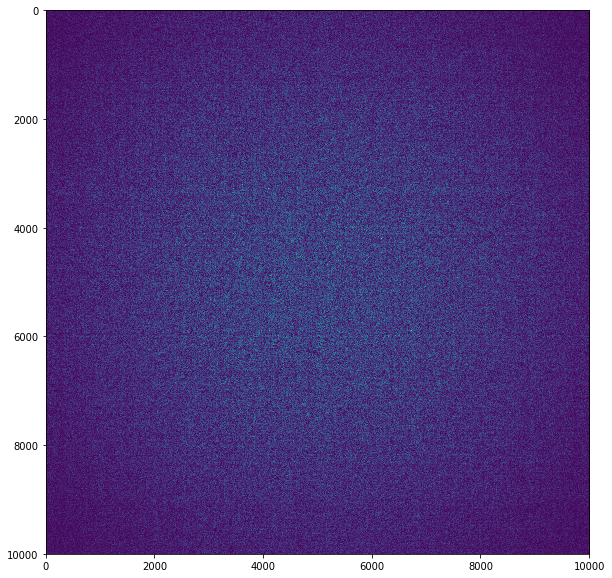

In [146]:
plt.imshow(np.abs(comb))

In [107]:
Image.fromarray(np.abs(comb)).save('noise_v2_big.tiff')

In [111]:
comb_gauss = get_diffracted(gauss,np.ones((x,y)),dist,wavelength)

In [112]:
np.sum(np.abs(comb_gauss))

0.6219942232362519

In [159]:
#Test gauss beam + noise
x = 512
y = 512
dist = 100
wavelength = 0.525

num_imgs = 5

gauss = get_gauss_beam(x,y)
noise = get_noise(x,y)

noises = []
for i in range(num_imgs):
    n_ap = get_noise(x,y)
    noises.append(n_ap)

In [160]:
comb = get_diffracted(gauss,np.ones((x,y)),dist,wavelength)

combs = [comb]

for i in range(num_imgs):
    #combs.append(get_diffracted(combs[i],noises[i],dist,wavelength))
    combs.append(get_diffracted(gauss,noises[i],dist,wavelength))

print()
#wave = gen_noise_random_size(x,y)

In [161]:
ani = WaveAnimationWithHist(combs)
ani.close()
HTML(ani.to_html5_video())

In [162]:
plt.imsave('noise_gen_v2_test_2.tif', np.abs(combs[i]))

In [ ]:
window = combs[4][3700:3700+2500,7000:7000+2500]
#window=gauss
abs_comb = np.abs(window)

fig,ax = plt.subplots(1,3)

ax[0].set_title("Amplitude")
im0 = ax[0].imshow(abs_comb)
fig.colorbar(im0,ax=ax[0])
#ax[0].get_xaxis().set_visible(False)
#ax[0].get_yaxis().set_visible(False)

ax[1].set_title("Phase")
im1 = ax[1].imshow(np.angle(window))
fig.colorbar(im1,ax=ax[1])

ax[2].set_title("Histogram")
ax[2].hist(abs_comb.flatten(),100)

print()

#print(np.sum(np.abs(combs[0])))
#print(np.sum(np.abs(combs[1])))
#print(np.sum(np.abs(combs[2])))
#print(np.sum(np.abs(combs[3])))
#print(np.sum(np.abs(combs[4])))
#print(np.sum(np.abs(combs[5])))
#print(np.sum(np.abs(combs[6])))

In [ ]:
windows = []
for frame in combs:
    windows.append(frame[3700:3700+2500,7000:7000+2500])
    
ani = WaveAnimationWithHist(windows)
ani.close()
HTML(ani.to_html5_video())

In [ ]:
plt.imshow(abs_comb)

In [163]:
#No noise
plane = np.cos(np.zeros((x,y))) + 1j*np.sin(np.zeros((x,y)))
plane_comb = get_diffracted(gauss,plane,dist,wavelength)

plane_combs = [plane_comb]

for i in range(num_imgs):
    plane_combs.append(get_diffracted(plane_combs[i],plane,dist,wavelength))

print()
#wave = gen_noise_random_size(x,y)

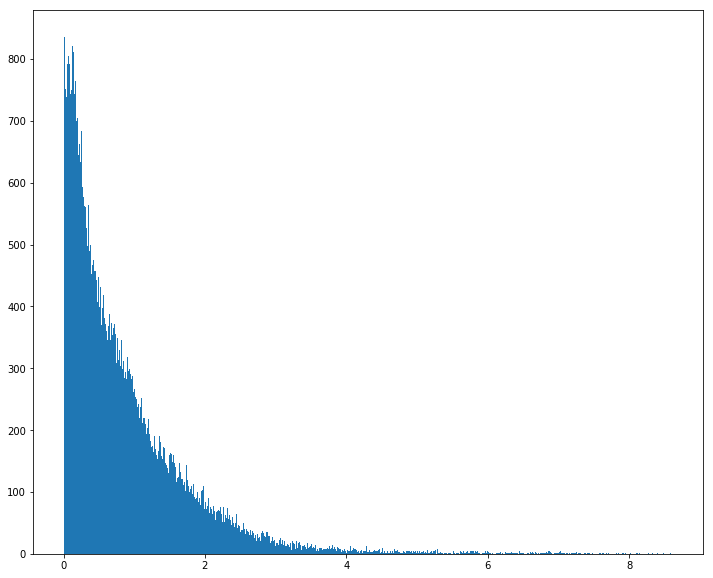

In [327]:
n = get_noise(x,y)
#plt.hist(intensity(n).flatten(),50)
plt.hist(np.power(np.abs(n).flatten(),2),1000)
print()

In [265]:
x = 2048
y = 2048

#real = np.random.normal(scale=0.5,size=(x,y))
#imag = np.random.normal(scale=0.5,size=(x,y))
gauss = get_gauss_beam(x,y)

mises_noise = get_noise(x,y,10)

print(np.mean(np.abs(mises_noise)))

wave = gauss * mises_noise#(np.cos(imag)+1j*np.sin(imag))

0.8647314331349362


In [266]:
print(np.sum(np.abs(gauss)))
print(np.sum(np.abs(wave)))
print(np.sum(np.abs(wave))/np.sum(np.abs(gauss)))

0.6217925695102945
0.5356150904994961
0.8614047783191278


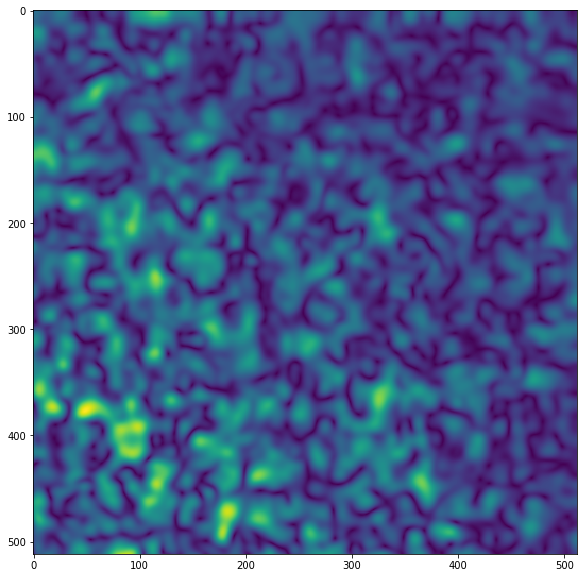

In [274]:
#plt.hist(np.abs(wave.flatten()),50) # -- Rayleigh distribution
#plt.hist(np.angle(mises_noise.flatten()),50) # -- Von mises distribution
#plt.hist(imag.flatten(),50) # -- Normally distributed
#plt.hist(np.abs(mises_noise.flatten()),50) # -- Rayleigh distribution
#plt.imshow(np.abs(wave))
plt.imshow(np.abs(wave)[:1024-512,1024+512:])
print()

### Add Fringe

In [16]:
def intensity(img):
    return np.real(img)**2 + np.imag(img)**2

def get_log_abs(img):
    return np.log(np.abs(np.fft.fftshift(np.fft.fft2(img))))

In [17]:
'''
    wavelength - um
    dx - um
    dy - um
    a - degree 
    b - degree
    x - width of output in px
    y - height of output in px
    
    return:
    real - cos(phase)
    imag - phase
'''
def gen_plane_wave(wavelength,dx,dy,a,b,x,y):
    alpha=math.cos(a/180*math.pi)
    beta=math.cos(b/180*math.pi)
    
    if not (1-(alpha**2)-(beta**2) > 0):
        print(alpha**2)
        print(1-(alpha**2)-(beta**2))
        raise ValueError("Insert a valid pair of director angles. Remember that cos^2(a) + cos^2(b) <= 1")
    
    gamma=math.sqrt(1-(alpha**2)-(beta**2))
    
    # wavelength=wavelength*0.001 # Convert wavelength to um
    
    k3 = 3*2*math.pi/wavelength #TODO: Currently assuming lambda is wavelength
    
    if k3 * alpha * dx > (2*math.pi):
        angle = math.degrees(math.acos((2*math.pi) / (k3 * dx)))
        
        raise ValueError("In order to fulfill the sampling theorem, the director angle a >= " + str(angle))
    
    if k3 * beta * dx > (2*math.pi):
        angle = math.degrees(math.acos((2*math.pi) / (k3 * dy)))
        
        raise ValueError("In order to fulfill the sampling theorem, the director angle b >= " + str(angle))
        
    k = 2 * math.pi / wavelength
    
    n = k * gamma
    p=(np.pi/4) # -RBC
    #p=(np.pi/2)-(np.pi*(17/100)) # - Noisy Beads
    #p = np.pi-(5/9)*np.pi # - Hydrogel
    
    p = (np.pi*1.05)/8  # - Water Beads
    
    #p = math.cos(10/(180*math.pi))
    
    l = np.cos(p)*(np.arange(x) - (x/2) + 1) * dx * alpha * k
    m = np.sin(p)*(np.arange(y) - (y/2) + 1) * dy * beta * k
    
    l = np.broadcast_to(l, (y,x)).transpose()
    m = np.broadcast_to(m, (x,y))
    n = np.broadcast_to(n, (x,y))
    
    phase = l + m + n
    
    plt.imshow(phase)
    #plt.axis('off')
    
    wavefront_real = np.cos(phase)
    wavefront_imaginary = np.sin(phase)
    
    return wavefront_real, wavefront_imaginary

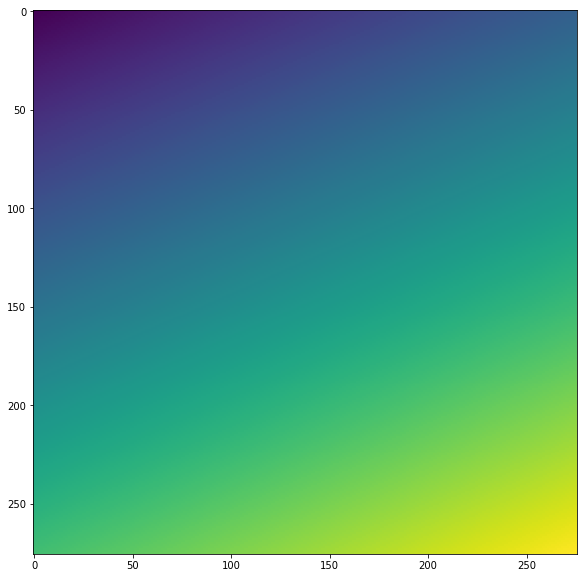

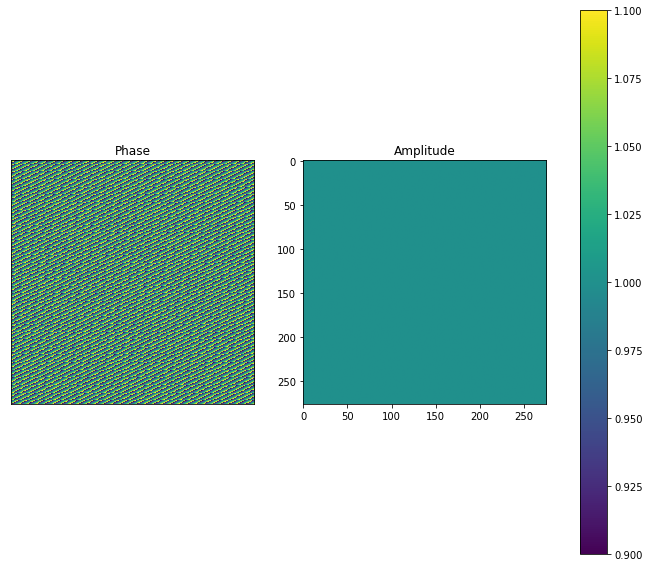

In [276]:
real, imaginary = gen_plane_wave(0.6328,3.24,3.24,87.05,87.05,276,276)

wave = real+1j*imaginary

fig,ax = plt.subplots(1,2)

ax[0].set_title("Phase")
ax[0].imshow(np.angle(wave))
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].set_title("Amplitude")
bax = ax[1].imshow(np.abs(wave))

bbar = fig.colorbar(bax,ax=ax)

(-0.5, 275.5, 275.5, -0.5)

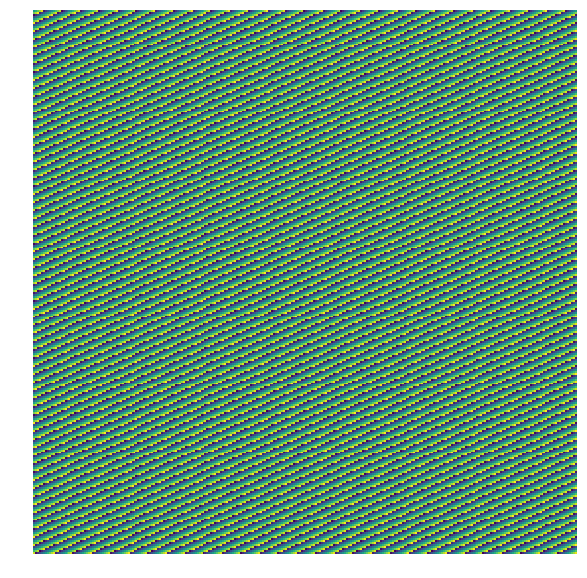

In [277]:
plt.imshow(np.angle(wave))
plt.axis('off')

In [348]:
wavelength=0.6328 # - um
z=3000 # 1.503 # - um
dx=4.24 # - um
dy=4.24 # - um

#a=87.05 # deg #RBC
#b=87.05 # deg #RBC

a=88.55 # deg - Water Beads
b=88.55 # deg - Water Beads

x = 286
y = 286

oct_bead_settings = {'wavelength':0.6328,'dx':5.04,'dy':5.04,'a':87.05,'b':87.05,'p':0}

In [19]:
def hologram_image_from_path_4_parts_repeat(filename,subdir="",output_sub_folder="",noisy_obj=False,save_img=False,compress=1):    
    img = cv2.imread(f'{input_folder}{subdir}/{filename}')
    
    if img is None:
        print(f'{input_folder}{subdir}{filename}' + " is None")
        return None
    
    img = np.rot90(img)
    
    for i in tqdm.tqdm_notebook(range(100)):
        hologram_image(img[:x,:y],filename[:-4]+'_0_'+str(i),subdir,output_sub_folder,noisy_obj=noisy_obj,show_img=False,save_img=save_img,compress=compress)
        hologram_image(img[img.shape[0]-x:,:y],filename[:-4]+'_1_'+str(i),subdir,output_sub_folder,noisy_obj=noisy_obj,show_img=False,save_img=save_img,compress=compress)
        hologram_image(img[:x,img.shape[1]-y:],filename[:-4]+'_2_'+str(i),subdir,output_sub_folder,noisy_obj=noisy_obj,show_img=False,save_img=save_img,compress=compress)
        hologram_image(img[img.shape[0]-x:,img.shape[1]-y:],filename[:-4]+'_3_'+str(i),subdir,output_sub_folder,noisy_obj=noisy_obj,show_img=False,save_img=save_img,compress=compress)

def hologram_image_from_path(filename,subdir="",output_sub_folder="",noisy_obj=False,show_img=True,save_img=False,compress=1):
    img = cv2.imread(f'{input_folder}{subdir}/{filename}')
    
    return hologram_image(img,filename,subdir,output_sub_folder,noisy_obj=noisy_obj,show_img=show_img,save_img=save_img,compress=compress)
    
def hologram_image_from_path_4_parts(filename,subdir="",output_sub_folder="",noisy_obj=False,save_img=False,compress=1):    
    img = cv2.imread(f'{input_folder}{subdir}/{filename}')
    
    if img is None:
        print(f'{input_folder}{subdir}{filename}' + " is None")
        return None
    
    img = np.rot90(img)
    
    hologram_image(img[:x,:y],filename[:-4]+'_0',subdir,output_sub_folder,noisy_obj=noisy_obj,show_img=False,save_img=save_img,compress=compress)
    hologram_image(img[img.shape[0]-x:,:y],filename[:-4]+'_1',subdir,output_sub_folder,noisy_obj=noisy_obj,show_img=False,save_img=save_img,compress=compress)
    hologram_image(img[:x,img.shape[1]-y:],filename[:-4]+'_2',subdir,output_sub_folder,noisy_obj=noisy_obj,show_img=False,save_img=save_img,compress=compress)
    hologram_image(img[img.shape[0]-x:,img.shape[1]-y:],filename[:-4]+'_3',subdir,output_sub_folder,noisy_obj=noisy_obj,show_img=False,save_img=save_img,compress=compress)
    
def hologram_image(img,filename,subdir="",output_sub_folder="",noisy_obj=False,show_img=True,save_img=False,compress=1):
    if img is None:
        print(f'{input_folder}{subdir}{filename}' + " is None")
        return None
    
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #print(img.shape)
    gray = img #[:792,:1360]

    #gray = (gray-np.min(gray))/(np.max(gray)-np.min(gray)) * math.pi
    
    x,y = gray.shape
    
    #obj = np.cos(gray)+1j*np.sin(gray) # Create object with the same real and imaginary values
    #obj = np.multiply(gray,obj)
    #obj = np.ones((x,y))+(1j*gray) # Create object with the same real and imaginary values
    
    if (np.max(gray)-np.min(gray)) > 0:
        phase = (gray-np.min(gray))/(np.max(gray)-np.min(gray)) * 5 * math.pi
    else:
        phase = gray
    
    obj = np.cos(phase)+1j*np.sin(phase) # Create object with the same real and imaginary values
    #obj = np.multiply(phase*2/math.pi,obj)
    
    #obj = np.ones((x,y)) + 1j*phase

    real, imaginary = gen_plane_wave(wavelength,dx,dy,a,b,x,y)
    
    plane_wave = real + 1j*imaginary

    if noisy_obj:
        print(x)
        print(y)
        print(obj.shape)
        object_wave = get_diffracted(obj, get_noise(x,y), z, wavelength)
        #object_wave = get_noise(x,y)
        
        # For RBC
        #right_shift = np.flip((np.arange(y) / (y))+0.5)
        #print(right_shift)
        #object_wave = object_wave*np.broadcast_to(right_shift, (x,y))
        
        #comb_wave = plane_wave/1 + (object_wave*1)
    else:
        object_wave = get_diffracted(obj,np.ones((x,y)),z,wavelength) # object_propogation(obj,wavelength,z,dx,dy,noisy=None)
        
        #comb_wave = plane_wave + (object_wave*1)
    
    #print(np.min(np.abs(plane_wave)))
    #print(np.max(np.abs(plane_wave)))
    
    #print(np.min(np.abs(object_wave)))
    #print(np.max(np.abs(object_wave)))
    
    mean_obj = np.mean(object_wave)
    #shifted_obj_wave = ((object_wave-mean_obj)*1) + mean_obj
    
    comb_wave = plane_wave/1 + (object_wave*1)
    
    #print(comb_wave)
    
    #no_amp = np.ones((x,y)) + np.angle(comb_wave)
    #plane = np.angle(plane_wave + plane_wave) + np.ones((x,y))

    inten = intensity(comb_wave)
    
    if show_img:
        if noisy_obj:
            fft = np.log(np.abs(np.fft.fftshift(np.fft.fft2(inten))+1))
            
            #sp.misc.imsave(f'output_noisy_80_new_comp{compress}.png',inten) 
            #sp.misc.imsave(f'output_noisy_80_new_comp{compress}_noise.png',noise)
            #sp.misc.imsave(f'output_noisy_80_new_comp{compress}_fft.png',fft)
        #plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(obj)))+1))
        #plt.imshow(np.angle(np.fft.fftshift(np.fft.fft2(comb_wave))))
        #plt.imshow(np.angle(object_wave))
        plt.imshow(inten,cmap=plt.cm.gray)
        plt.axis('off')
    
    if save_img:
        if noisy_obj:
            np.save(f'{noisy_output_folder}{output_sub_folder}/{filename}',inten)
        else:
            np.save(f'{clean_output_folder}{output_sub_folder}/{filename}',inten)
    
    return inten

In [403]:
#water_x = 816*1 # - Hydrogel
#water_y = 736*1 # - Hydrogel

water_x = 272*1 # - Water
water_y = 272*1 # - Water

#water_x = 512
#water_y = 512

#water_x = 2720*1 # - Water
#water_y = 2720*1 # - Water

#water_x = 500*1 # - RBC
#water_y = 888*1 # - RBC

(-0.5, 511.5, 511.5, -0.5)

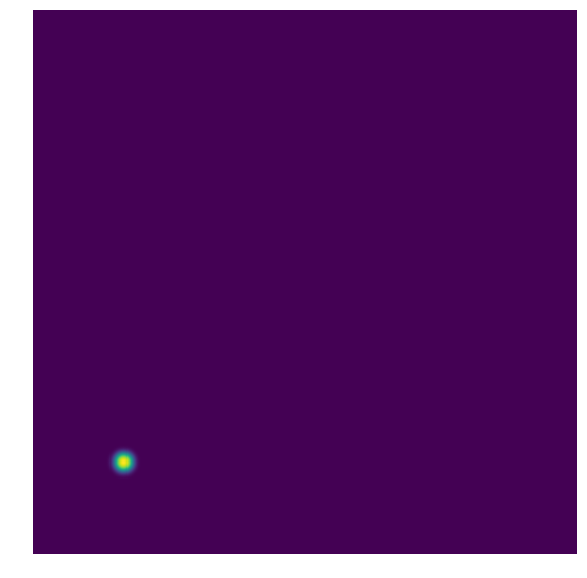

In [316]:
def gen_bead(r=50):
    circ = np.zeros((water_x,water_y))

    #r = 80*1 # - Hydrogel
    #r = 50*1 # - Water
    #r = 500*1 # - Water
    #r = 90*1 # - OCT Beads
    r2 = np.power(r,2)
    
    pos_x = randint(r,water_x-(r))
    #pos_x = 136
    pos_y = randint(r,water_y-(r))
    #pos_y = 136
    
    for i in range(water_x):
        x2 = np.power(i-pos_x,2)
        for j in range(water_y):
            #print(abs_dist(a,b))
            #circ[i][j] = np.cos(max(abs_dist(i,j)/water_x*pi,0)) # np.cos((np.abs(50-i)+np.abs(50-j))/100)
            #circ[i][j] = max(0.0,np.cos((i)/water_x*np.pi))
            circ[i][j] = np.power(max(0,r2-(x2+np.power(j-pos_y,2))),1/2)
            
    circ = sp.ndimage.filters.gaussian_filter(circ,sigma=3)
    
    return circ

plt.imshow(gen_bead(10))
plt.axis('off')

In [404]:
bead = gen_bead()

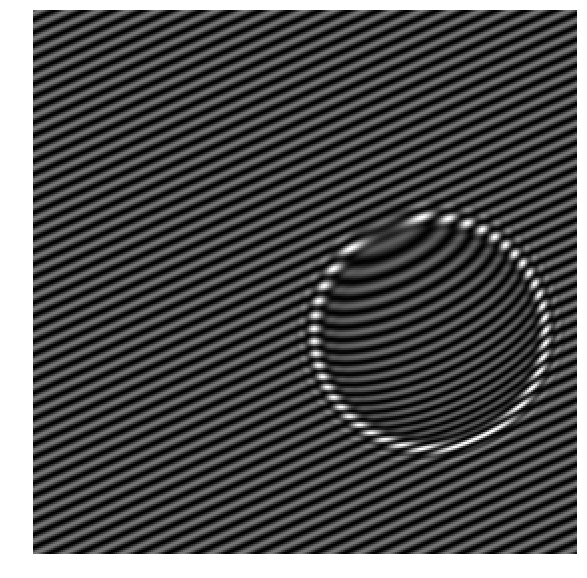

In [416]:
i=0
z=-30
clean_img = hologram_image(bead,f'bead_{i}',output_sub_folder='/bead_focus_test',show_img=True,save_img=False, noisy_obj=False)
#imsave('clean_img_2.png',clean_img)
#noisy_img = hologram_image(bead,f'bead_{i}',output_sub_folder='/beads_hydrogel',show_img=True,save_img=False, noisy_obj=True)#

272
272
(272, 272)


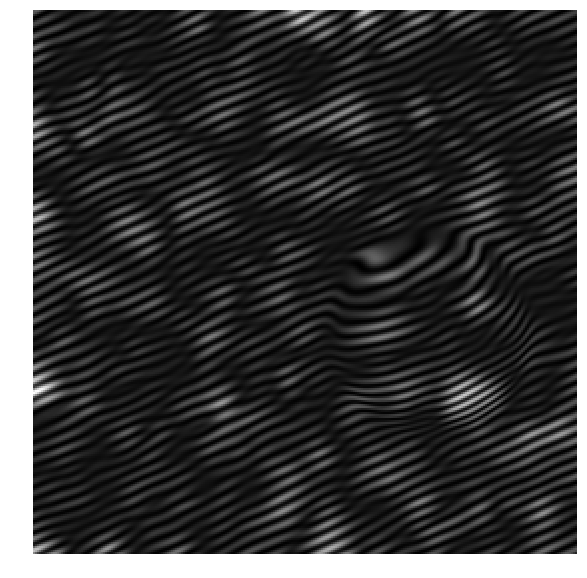

In [406]:
noisy_img = hologram_image(bead,f'bead_{i}',output_sub_folder='/bead_focus_test',show_img=True,save_img=False, noisy_obj=True)

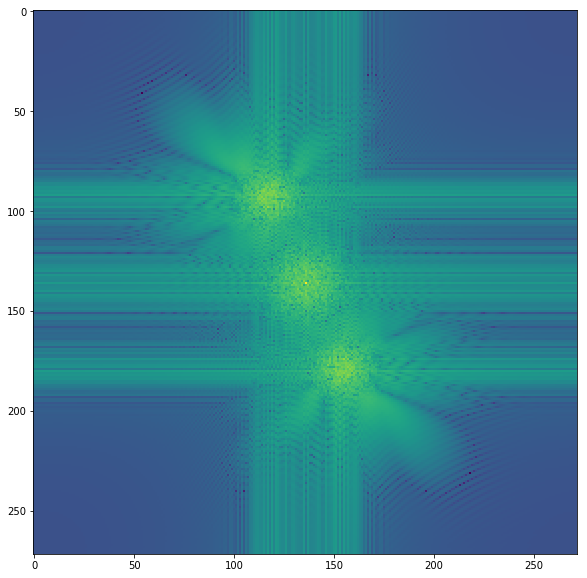

In [418]:
plt.imshow(get_log_abs(noisy_img))

2.2341280407061896



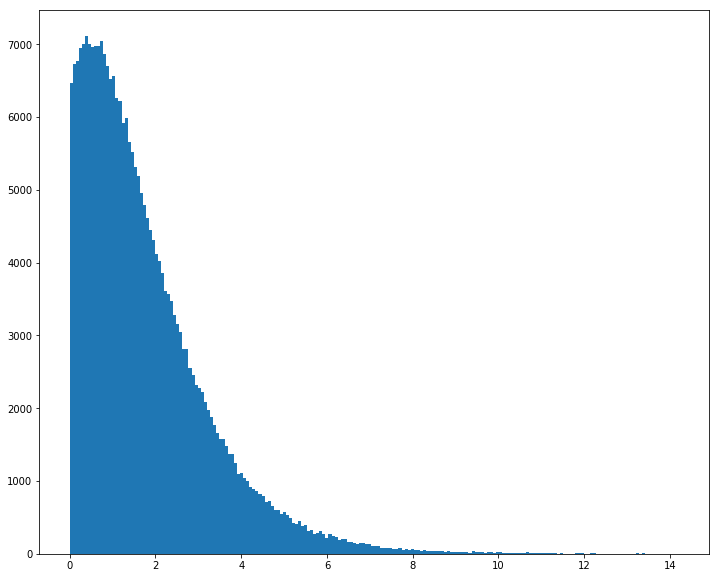

In [400]:
print(noisy_img[0][0])
plt.hist(noisy_img.flatten(),200)
print()

In [422]:
Image.fromarray(noisy_img).save('noisy_image_test.tiff')